In [1]:
import numpy as np

class SignalGenerator:
    # Constants for varying amplitude distribution
    EXPONENTIAL = 1
    UNIFORM = 2
    CRESCENDO = 3

    def __init__(self, f=8820, melody_file=None):
        self.setup_constants(f)
        self.setup_note2frequency()
        self.setup_melodies(melody_file)

    def setup_constants(self, f):
        self.sampling_frequency = f
        self.note_duration = 0.4
        self.pause_duration = 0.01
        self.pitch_mismatches = np.array([0.975, 1.025])

    def setup_note2frequency(self):
        octave = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        notes = [octave[note] + str(oct) for oct in range(1, 8) for note in range(12)]
        n = np.arange(4, 88)
        self.dict_note2frequency = dict(zip(notes, 440.0 * 2.0 ** ((n - 49) / 12)))

    def setup_melodies(self, melody_file=None):
        if melody_file:
            with open(melody_file, 'r') as file:
                melodies = file.readlines()
            self.melodies = [melody.strip().split(', ') for melody in melodies]
        else:
            # Placeholder: Use a default melody if no file is provided
            self.melodies = [['C4', 'E4', 'G4'], ['A4', 'C5', 'E5']]  # Example default melody

    @property
    def pause(self):
        return np.zeros(int(self.pause_duration * self.sampling_frequency))

    @property
    def nr_melodies(self):
        return len(self.melodies)

    @property
    def nr_pitch_mismatches(self):
        return len(self.pitch_mismatches)

    @property
    def nr_hypotheses(self):
        return self.nr_melodies * self.nr_pitch_mismatches

    @property
    def nr_note_samples(self):
        return int(self.note_duration * self.sampling_frequency)

    def note2frequency(self, note):
        return self.dict_note2frequency[note]

    def get_melody(self, idx_melody):
        return self.melodies[idx_melody]

    def nr_notes(self, melody):
        return len(melody)

    def get_note(self, idx_note, melody):
        return melody[idx_note]

    def generate_melody(self, idx_melody, pitch_mismatch=1, nr_tones=1):
        if nr_tones not in [1, 3]:
            raise ValueError('nr_tones should be 1 or 3')
        time_range = np.arange(self.nr_note_samples) / self.sampling_frequency
        melody = np.empty(0)
        for idx_note in range(self.nr_notes(self.get_melody(idx_melody))):
            f = pitch_mismatch * self.note2frequency(self.get_note(idx_note, self.get_melody(idx_melody)))
            note = np.cos(2 * np.pi * f * time_range + 2 * np.pi * np.random.uniform())
            if nr_tones == 3:
                note += np.cos(2 * np.pi * 3 * f * time_range + 2 * np.pi * np.random.uniform())
                note += np.cos(2 * np.pi * 5 * f * time_range + 2 * np.pi * np.random.uniform())
                note *= 1 / np.sqrt(3)
            melody = np.append(melody, note * self.get_amplitude(idx_note, self.UNIFORM))
            melody = np.append(melody, self.pause)
        return melody

    def get_amplitude(self, idx_note, opt=None):
        if opt is None:
            return 1
        if opt == self.EXPONENTIAL:
            return np.random.exponential(1)
        if opt == self.CRESCENDO:
            return 0.8 + 0.4 * idx_note / 12
        if opt == self.UNIFORM:
            return np.random.uniform(0.8, 1.2)

    def generate_random_melody(self, snr_db, nr_tones=1):
        idx_melody = np.random.randint(self.nr_melodies)
        pitch_mismatch = self.pitch_mismatches[np.random.randint(self.nr_pitch_mismatches)]
        melody = self.generate_melody(idx_melody, pitch_mismatch, nr_tones)
        snr_lin = 10 ** (snr_db / 10)
        melody += np.sqrt(1 / snr_lin) * np.random.randn(len(melody))
        return melody, idx_melody, pitch_mismatch

    def generate_random_melodies(self, nr_generate, snr_db, nr_tones=1):
        melodies = np.zeros((len(self.generate_random_melody(snr_db)[0]), nr_generate))
        ids = np.empty(nr_generate)
        mismatches = np.empty(nr_generate)
        for idx_generate in range(nr_generate):
            melody, idx_melody, mismatch = self.generate_random_melody(snr_db, nr_tones)
            melodies[:, idx_generate] = melody
            ids[idx_generate] = idx_melody
            mismatches[idx_generate] = mismatch
        return melodies, ids, mismatches


# Example usage in a Jupyter Notebook:
sg = SignalGenerator()

# Generate random melodies (replace snr_db and nr_generate as needed)
melodies, true_ids, true_mismatches = sg.generate_random_melodies(nr_generate=5, snr_db=10, nr_tones=1)

# Print results
print("Generated Melodies:\n", melodies)
print("Melody IDs:\n", true_ids)
print("Pitch Mismatches:\n", true_mismatches)

Generated Melodies:
 [[-0.64489862 -0.66598072  0.3120284   0.72388561  0.31414202]
 [-0.21207198  0.30433142 -0.43544638  1.21935001  0.69835419]
 [-0.16630961  0.26913073 -0.48779255  1.28529249  0.54173042]
 ...
 [ 0.58311804  0.61500247 -0.29693706 -0.4598352  -0.01055888]
 [ 0.46368346  0.17843983 -0.25972881 -0.1380275   0.4218552 ]
 [-0.40761978  0.40060119  0.00506218 -0.40561498  0.37614312]]
Melody IDs:
 [1. 1. 0. 0. 0.]
Pitch Mismatches:
 [0.975 1.025 0.975 0.975 0.975]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import typing
from typing import Tuple, Union, Any
from tqdm import tqdm

In [3]:
def setup_note2frequency() -> dict[str, int]:
    octave = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    notes = [octave[note] + str(oct_) for oct_ in range(1, 8) for note in range(12)]
    n = np.arange(4, 88)
    return dict(zip(notes, 440.0 * 2.0 ** ((n - 49) / 12)))

In [4]:
class Classifier:
    def __init__(self):  # melody, nr_tone_samples
        # Constants
        self.note_duration = 0.4
        self.pause_duration = 0.01
        self.pitch_mismatches = np.array([0.975, 1.025])

        # Set up methods
        self.dict_note2frequency = setup_note2frequency()
        self.stored_melodies_notes = self.setup_given_melodies()[0]
        self.stored_melodies_frequencies = self.setup_given_melodies()[1]
        self.melodies_mismatch1 = self.setup_given_melodies()[2]
        self.melodies_mismatch2 = self.setup_given_melodies()[3]

    def setup_given_melodies(self) -> tuple[
        list[list[str]], list[list[int]], list[list[Union[int, Any]]], list[list[Union[int, Any]]]]:
        with open('melodies.txt', 'r') as file:
            melodies = file.readlines()

        # Splits the string into a nested list with the tones (expressed in notes)
        melodies_note = [m.strip().split(', ') for m in melodies]

        # Expresses the melodies as a nested list of frequencies for each tone
        melodies_freq = [[self.dict_note2frequency[n] for n in m] for m in melodies_note]

        m_mismatch_1 = [[n * self.pitch_mismatches[0] for n in m] for m in melodies_freq]
        m_mismatch_2 = [[n * self.pitch_mismatches[1] for n in m] for m in melodies_freq]

        return melodies_note, melodies_freq, m_mismatch_1, m_mismatch_2

    def single_tone_observation_matrix(self):
        """
        Observation matrix
        :return ndarray
        """
        # for k in range(self.nr_tone_samples):
        F = [self.melodies_mismatch1, self.melodies_mismatch2]

        H = np.empty((20, 12, self.nr_tone_samples_div, 2))

        #Pick the frequency of each element in H:
        alpha = 0
        for pitch_mismatch in F:  # 2 mismatches
            n = 0  # row i H
            if alpha == 1:
                n = n + 10
            for m in pitch_mismatch:  # 10 melodies in m
                j = 0  # column in H
                for f_nj in m:  # 12 notes in a melody
                    H_nj = np.array([1, 0])
                    #Now you have the frequency f_nj
                    for k in range(self.nr_tone_samples_div):
                        new_row = np.array([np.cos(2 * np.pi * f_nj / 8820 * k), np.sin(2 * np.pi * f_nj / 8820 * k)])
                        H_nj = np.vstack([H_nj, new_row])
                    H_nj = np.delete(H_nj, 0, axis=0)
                    H[n, j] = H_nj
                    j += 1
                n += 1
            alpha += 1
            
        print("Observation Matrix H:\n", H)
        return H

    def three_tone_observation_matrix(self):
        """:return tough stuff"""

        # for k in range(self.nr_tone_samples):
        F = [self.melodies_mismatch1, self.melodies_mismatch2]

        H = np.empty((20, 12, self.nr_tone_samples_div, 6))

        #Pick the frequency of each element in H:
        alpha = 0
        for pitch_mismatch in F:  # 2 mismatches
            n = 0  # row i H
            if alpha == 1:
                n = n + 10
            for m in pitch_mismatch:  # 10 melodie in m
                j = 0  #column in H
                for f_nj in m:  # 12 notes in a melody
                    H_nj = np.array([1, 0, 1, 0, 1, 0])
                    #Now you have the frequency f_nj
                    for k in range(self.nr_tone_samples_div):
                        new_row = np.array([np.cos(2 * np.pi * f_nj / 8820 * k), np.sin(2 * np.pi * f_nj / 8820 * k),
                                            np.cos(6 * np.pi * f_nj / 8820 * k), np.cos(6 * np.pi * f_nj / 8820 * k),
                                            np.cos(10 * np.pi * f_nj / 8820 * k), np.cos(10 * np.pi * f_nj / 8820 * k)])
                        H_nj = np.vstack([H_nj, new_row])
                    H_nj = np.delete(H_nj, 0, axis=0)
                    H[n, j] = H_nj
                    j += 1
                n += 1
            alpha += 1

        return H

    def setup_y_n(self) -> list[int]:
        y = []

        for n in range(12):
            y.append(self.melody[n * self.nr_tone_samples:(n * self.nr_tone_samples + self.nr_tone_samples_div)])
            n += 1
        return y

    def single_tone_classifier(self, melody) -> tuple[int, float]:
        """
        :return: our hypothesis on melody and pitch mismatch
        """
        self.melody = melody

        nr_samples = len(melody)
        tone = melody[:int(nr_samples / 12)]  # all notes the same length => the length of each note is obtained here
        self.nr_tone_samples = int(len(tone))
        self.nr_tone_samples_div = int(len(tone)/10)
        self.y = self.setup_y_n()
        self.H = self.single_tone_observation_matrix()

        # determine the hypothesis j_hat
        j_max = 0
        sum_max = 0
        for j in range(20):  # melodies
            sum = 0
            for n in range(12):  # number of tones
                sum += (np.linalg.norm(np.matmul(np.transpose(self.H[j][n]), self.y[n]))) ** 2
            if sum > sum_max:
                sum_max = sum
                j_max = j

        if j_max < 10:
            cl_id = j_max
            cl_mism = 0.975
        else:
            cl_id = j_max - 10
            cl_mism = 1.025

        return cl_id, cl_mism

    def three_tone_classifier(self, melody):

        self.melody = melody

        # determines the amount of samples
        nr_samples = len(melody)
        tone = melody[:int(nr_samples / 12)]  #all notes the same length => the length of each note is obtained here
        self.nr_tone_samples = int(len(tone))
        self.nr_tone_samples_div = int(len(tone)/10)
        self.H = self.three_tone_observation_matrix()
        self.y = self.setup_y_n()

        # determine the hypothesis j_hat
        j_max = 0
        sum_max = 0
        for j in range(20):  # melodies
            sum = 0
            for n in range(12):  # number of tones
                sum += (np.linalg.norm(np.matmul(np.transpose(self.H[j][n]), self.y[n]))) ** 2
            if sum > sum_max:
                sum_max = sum
                j_max = j

        if j_max < 10:
            cl_id = j_max
            cl_mism = 0.975
        else:
            cl_id = j_max - 10
            cl_mism = 1.025

        return cl_id, cl_mism


def monte_carlo_simulation():
    """Determines which classifier that works the best. Plot the misclassification as function of the SNR.
    The interesting SNR range is between -50 dB and -10 dB."""
    sg = SignalGenerator()
    clsfier = Classifier()

    single_or_three_tone = 1  # single-tone melody or three-tone melody

    sim_nr = 5  # the number of simulations
    c_id= -1
    c_mismatch = -1
    nr_of_notes_gen = [1, 3, 1, 3]
    nr_of_notes_cls = [1, 1, 3, 3]

    for run in range(4):
        success_list = []
        SNR_DB_list = []
        classification_sum = 0
        for SNR_DB in tqdm(range(-50, 0, 10)):
            melodies, ids, mismatches = sg.generate_random_melodies(sim_nr, SNR_DB, nr_of_notes_gen[run])
            for melody_index in range(sim_nr):
                if nr_of_notes_cls[run] == 1:
                    c_id, c_mismatch = clsfier.single_tone_classifier(np.transpose(melodies)[melody_index])
                elif nr_of_notes_cls[run] == 3:
                    c_id, c_mismatch = clsfier.three_tone_classifier(np.transpose(melodies)[melody_index])

                if c_id != ids[melody_index] or c_mismatch != mismatches[melody_index]:
                    classification_sum += 1 / sim_nr

            SNR_DB_list.append(SNR_DB)
            success_list.append(classification_sum)
            classification_sum = 0

        plt.figure()
        plt.plot(SNR_DB_list, success_list)
        if run == 0:
            plt.title('Single Tone melody with a single-tone classifier varun ')
            img_name = 'single_tone_single_detector'
        elif run == 1:
            plt.title('Three Tone melody with a single-tone classifier varun ')
            img_name = 'three_tone_single_detector'
        elif run == 2:
            plt.title('Single Tone melody with a three-tone classifier varun ')
            img_name = 'single_tone_three_detector'
        elif run == 3:
            plt.title('Three Tone melody with a three-tone classifier varun ')
            img_name = 'three_tone_three_detector'

        plt.xlabel('SNR')
        plt.ylabel('Misclassification')
        # Show figure as desired.
        plt.savefig(img_name)
        plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

 20%|██        | 1/5 [00:00<00:02,  1.61it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

 40%|████      | 2/5 [00:01<00:01,  1.63it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

 60%|██████    | 3/5 [00:01<00:01,  1.60it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

 80%|████████  | 4/5 [00:02<00:00,  1.60it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

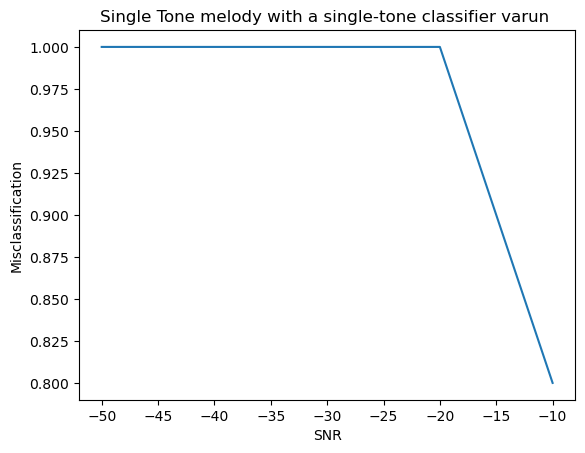

  0%|          | 0/5 [00:00<?, ?it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

 20%|██        | 1/5 [00:00<00:02,  1.65it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

 60%|██████    | 3/5 [00:01<00:01,  1.61it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

 80%|████████  | 4/5 [00:02<00:00,  1.59it/s]

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Observation Matrix H:
 [[[[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.83534810e-01  1.80718782e-01]
   [ 9.34681443e-01  3.55486427e-01]
   ...
   [-9.94859913e-01 -1.01260819e-01]
   [-9.60179623e-01 -2.79383412e-01]
   [-8.93880253e-01 -4.48305804e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.63163419e-01  2.68916767e-01]
   [ 8.55367544e-01  5.18021586e-01]
   ...
   [ 1.25059611e-01 -9.92149230e-01]
   [ 3.87258406e-01 -9.21971218e-01]
   [ 6.20926650e-01 -7.83868672e-01]]

  ...

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.70725461e-01  2.40191755e-01]
   [ 8.84615841e-01  4.66320505e-01]
   ...
   [-6.30860842e-01  7.75895997e-01]
   [-7.98756503e-01  6.01654426e-01]
   [-9.19885708e-01  3.92186544e-01]]

  [[ 1.00000000e+00  0.00000000e+00]
   [ 9.73

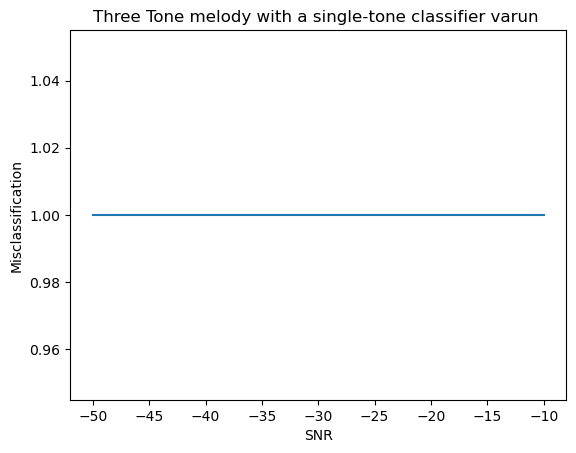

100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


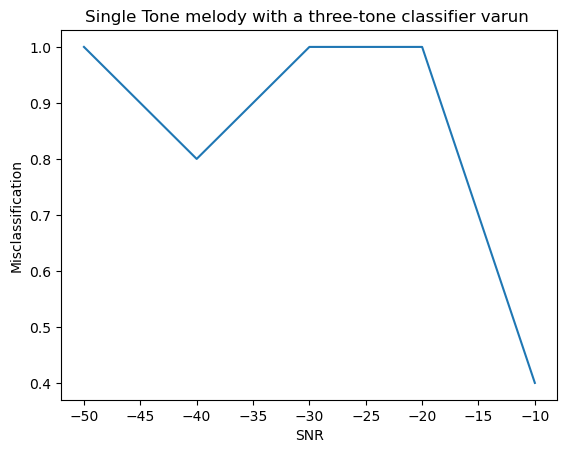

100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


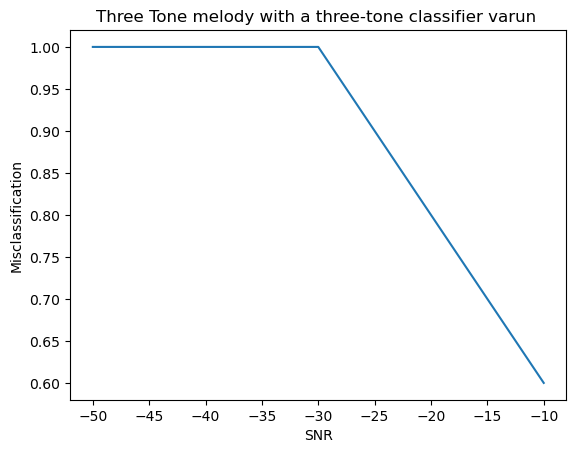

In [5]:
if __name__ == '__main__':
    monte_carlo_simulation()